# Regressorion with Orbit - Advance I
In this demo, we want to demonstartate further how to config orbit to perform regressions along with temporal components.  The config including different regularizations and we use a simulated data set to compare against ground truth. 

__IMPORTANT:__ This notebook only works under python 3.6 due to a bug related to matplotlib.

In [1]:
import pandas as pd
import numpy as np
import scipy
import gc

import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import pystan

from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull

from orbit.diagnostics.plot import plot_posterior_params
from orbit.constants.palette import QualitativePalette
from orbit.utils.simulation import make_ts_multiplicative, make_trend, make_seasonality, make_regression

In [2]:
# randomization is using numpy with this version
print("np version: {}".format(np.__version__))
print("scipy version: {}".format(scipy.__version__))
print("pystan version: {}".format(pystan.__version__))

np version: 1.18.2
scipy version: 1.4.1
pystan version: 2.19.1.1


## Simulation of regression with time-series

We first generate the coefficients for benchmarking.

In [3]:
SEED = 2020
NUM_OF_REGRESSORS = 20
SERIES_LEN = 100
SEASONALITY=12
# sample some coefficients
COEFS= np.random.default_rng(SEED).uniform(-0.3, 0.3, NUM_OF_REGRESSORS)
COEFS

array([-0.01901547,  0.00860534,  0.21839297,  0.13163212, -0.09990127,
        0.22899817,  0.01119892,  0.01393165,  0.13343322, -0.03193046,
        0.21021425,  0.11036176,  0.09954004,  0.26803024,  0.15218331,
       -0.24492215,  0.19565408,  0.03311207, -0.16130844,  0.28977535])

Now we generate observations $y$ such that $$y=l(t)+s(t)+r(t)$$
where $$r(t) = \sum_i \beta_i{x_{i,t}}^T $$ is our regression component with $\beta$ and $x_t$ represent coefficients and regressors at time $t$ respectively. 

In [7]:
trend = make_trend(series_len=SERIES_LEN, rw_loc=0.001, rw_scale=0.005, method='rw', seed=SEED)
seas = make_seasonality(series_len=SERIES_LEN, seasonality=SEASONALITY, method='discrete', seed=SEED)
X, y, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS)
y = np.expand_dims(y + trend + seas, -1)
print(y.shape, X.shape)

(100, 1) (100, 20)


In [8]:
x_cols = [f"x{x}" for x in range(1, NUM_OF_REGRESSORS + 1)]
response_col = "y"
dt_col = "date"
obs_matrix = np.concatenate([y, X], axis=1)
# make a data frame for orbit inputs
df = pd.DataFrame(obs_matrix, columns=[response_col] + x_cols)
# make some dummy date stamp
dt = pd.date_range(start='2016-01-04', periods=SERIES_LEN, freq="1W")
df['date'] = dt
df.head(5)

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,date
0,0.310136,0.345584,0.821618,0.000000,-1.303157,0.000000,0.000000,-0.536953,0.000000,0.364572,...,0.546713,-0.000000,-0.162910,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,2016-01-10
1,1.640513,0.008142,-0.000000,0.000000,1.006724,-2.711162,-1.889013,-0.174772,-0.000000,0.000000,...,-0.000000,-0.377605,2.042772,0.646703,0.663063,-0.000000,-1.648075,0.000000,0.000000,2016-01-17
2,0.634875,-1.227352,-0.683227,-0.072044,-0.000000,-0.098270,0.095483,0.035586,-0.506292,0.000000,...,-0.818230,0.000000,-0.501440,0.000000,-0.000000,0.914467,-0.020063,-1.248749,-0.000000,2016-01-24
3,-2.231022,0.000000,0.000000,-0.982188,-1.107373,0.199585,-0.000000,0.000000,0.759520,-1.648787,...,-0.000000,-0.810815,0.000000,0.253447,0.000000,-0.345216,-1.481818,-0.110011,-0.445828,2016-01-31
4,0.717702,0.775324,0.000000,-1.630849,-0.000000,0.883789,0.000000,-0.640243,-0.000000,0.000000,...,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.033000,-0.000000,0.332814,2016-02-07


## Regression with full regressors
Note that at this point, we simulate response with full rank of $x$ meaning all regressors contribute to the response.

In [9]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='auto_ridge',
    num_warmup=4000,
    num_sample=1000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

In [10]:
mod_fixed_ridge1 = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[10.0] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge1.fit(df=df)

In [11]:
mod_fixed_ridge2 = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='fixed_ridge',
    regressor_sigma_prior=[0.1] * NUM_OF_REGRESSORS,
    num_warmup=4000,
    num_sample=1000,
)
mod_fixed_ridge2.fit(df=df)

In [12]:
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge1 =np.median(mod_fixed_ridge1._posterior_samples['rr_beta'], axis=0)
coef_fixed_ridge2 =np.median(mod_fixed_ridge2._posterior_samples['rr_beta'], axis=0)

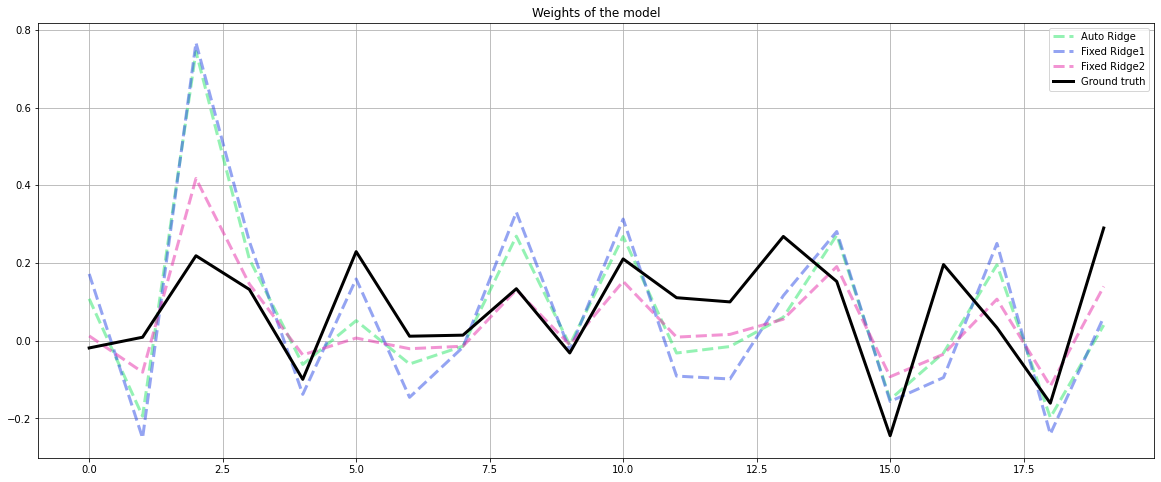

In [13]:
lw=3
plt.figure(figsize=(20, 8))
plt.title("Weights of the model")
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

The result looks decent to recover the true coefficients.

## Regression with sparsity
Now, we assume there exists some irrelevant regressors in our inputs and not all regressors kick it (with non-zero value) at each period.

In [26]:
X, y, coefs = make_regression(series_len=SERIES_LEN, coefs=COEFS, relevance=0.5, sparsity=0.5)
y = np.expand_dims(y + trend + seas, -1)
print(y.shape, X.shape)

(100, 1) (100, 20)


In [27]:
coefs

array([-0.01901547,  0.00860534,  0.21839297,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01393165,  0.        , -0.03193046,
        0.21021425,  0.        ,  0.        ,  0.        ,  0.15218331,
        0.        ,  0.19565408,  0.03311207,  0.        ,  0.28977535])

In [60]:
mod_lasso = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='lasso',
    num_warmup=4000,
    num_sample=4000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_lasso.fit(df=df)

In [74]:
mod_auto_ridge = DLTFull(
    response_col=response_col,
    date_col=dt_col,
    regressor_col=x_cols,
    seasonality=SEASONALITY,
    seed=SEED,
    regression_penalty='auto_ridge',
    auto_ridge_scale=1.0,
    num_warmup=4000,
    num_sample=4000,
    stan_mcmc_control={'adapt_delta':0.9},
)
mod_auto_ridge.fit(df=df)

In [75]:
# mod_fixed_ridge1 = DLTFull(
#     response_col=response_col,
#     date_col=dt_col,
#     regressor_col=x_cols,
#     seasonality=SEASONALITY,
#     seed=SEED,
#     regression_penalty='fixed_ridge',
#     regressor_sigma_prior=[10.0] * NUM_OF_REGRESSORS,
#     num_warmup=4000,
#     num_sample=4000,
# )
# mod_fixed_ridge1.fit(df=df)

In [76]:
# mod_fixed_ridge2 = DLTFull(
#     response_col=response_col,
#     date_col=dt_col,
#     regressor_col=x_cols,
#     seasonality=SEASONALITY,
#     seed=SEED,
#     regression_penalty='fixed_ridge',
#     regressor_sigma_prior=[0.05] * NUM_OF_REGRESSORS,
#     num_warmup=4000,
#     num_sample=4000,
# )
# mod_fixed_ridge2.fit(df=df)

In [77]:
coef_lasso = np.median(mod_lasso._posterior_samples['rr_beta'], axis=0)
coef_auto_ridge = np.median(mod_auto_ridge._posterior_samples['rr_beta'], axis=0)
# coef_auto_ridge = mod_auto_ridge._posterior_samples['rr_beta']
# coef_fixed_ridge1 =np.median(mod_fixed_ridge1._posterior_samples['rr_beta'], axis=0)
# coef_fixed_ridge2 =np.median(mod_fixed_ridge2._posterior_samples['rr_beta'], axis=0)

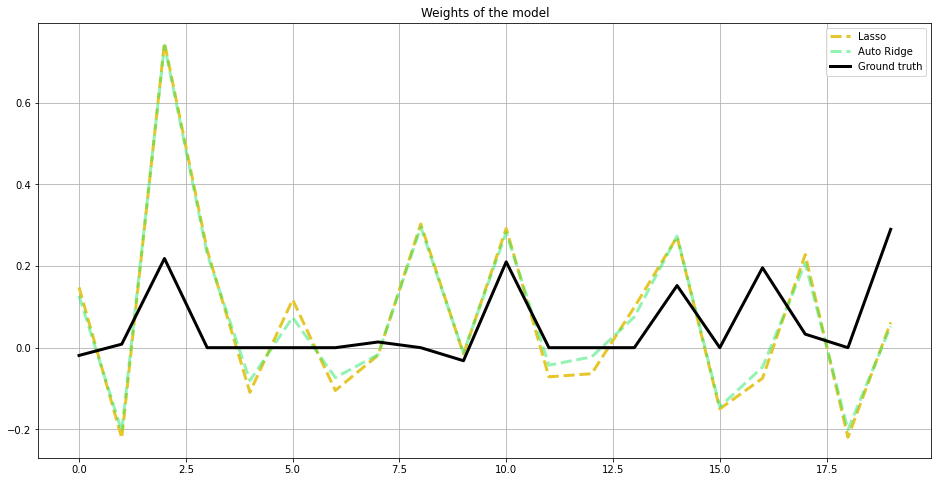

In [78]:
lw=3
plt.figure(figsize=(16, 8))
plt.title("Weights of the model")
plt.plot(coef_lasso, color=QualitativePalette.Line4.value[0], linewidth=lw, label="Lasso", alpha=1.0, linestyle='--')
plt.plot(coef_auto_ridge, color=QualitativePalette.Line4.value[1], linewidth=lw, label="Auto Ridge", alpha=0.5, linestyle='--')
# plt.plot(coef_fixed_ridge1, color=QualitativePalette.Line4.value[2], linewidth=lw, label="Fixed Ridge1", alpha=0.5, linestyle='--')
# plt.plot(coef_fixed_ridge2, color=QualitativePalette.Line4.value[3], linewidth=lw, label="Fixed Ridge2", alpha=0.5, linestyle='--')
plt.plot(coefs, color="black", linewidth=lw, label="Ground truth")
plt.legend()
plt.grid()

Again,  the result looks reasonable to the true coefficients with irrelevant regressors fed into the model. with high dimensional data,